In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [17]:
pip install opencv-python

# Import Necessary Modules & Packages

In [18]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from collections import deque
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Set The Hyperparameter

In [19]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

# Create, Split, and Check the Dataset

In [20]:
os.getcwd()

'C:\\Users\\kyled\\Downloads\\DataSet Workout'

In [21]:
DATA_DIR = os.path.join(os.getcwd(),"Input","WorkoutDataset")

In [22]:
DATA_DIR

'C:\\Users\\kyled\\Downloads\\DataSet Workout\\Input\\WorkoutDataset'

In [23]:
# DATA_DIR = r'/gdrive/My Drive/CIS515/Workout_DataSet'

## Create Train and Validation Dataset

In [24]:


train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


## Augment & Check Train Dataset

In [25]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

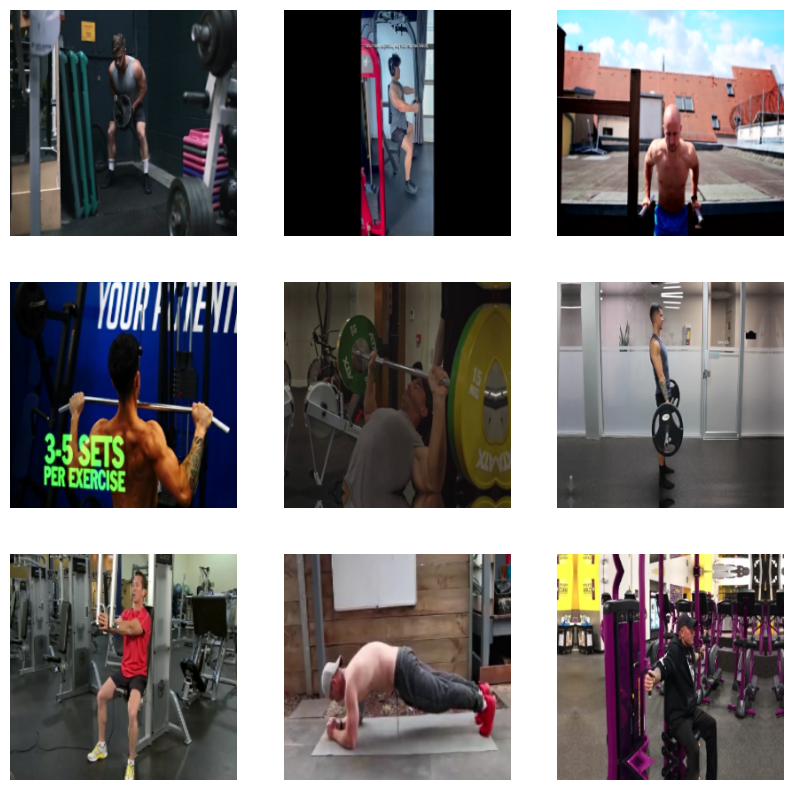

In [26]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Create, Compile, Train, and Evaluate The Model

In [27]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

In [28]:
x = pre_trained.output
# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00012),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

 batch_normalization_99 (BatchN  (None, 29, 29, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 29, 29, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 29, 29, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 29, 29, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 29, 29, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 29, 29, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 29, 29, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 14, 14, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 14, 14, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 14, 14, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 14, 14, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 14, 14, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 14, 14, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 6, 6, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 6, 6, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 6, 6, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

## Train Model

In [29]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 20, 
                                        mode = 'auto', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 300
#                             callbacks = [early_stopping_callback]
                           )

Epoch 1/300
390/390 [==============================] - 327s 830ms/step - loss: 11.0354 - accuracy: 0.1148 - val_loss: 6.1302 - val_accuracy: 0.1769
Epoch 2/300
390/390 [==============================] - 328s 841ms/step - loss: 5.5968 - accuracy: 0.2344 - val_loss: 4.2855 - val_accuracy: 0.2679
Epoch 3/300
390/390 [==============================] - 327s 838ms/step - loss: 4.1440 - accuracy: 0.3191 - val_loss: 3.5359 - val_accuracy: 0.3473
Epoch 4/300
390/390 [==============================] - 327s 838ms/step - loss: 3.5140 - accuracy: 0.3720 - val_loss: 2.8836 - val_accuracy: 0.4181
Epoch 5/300
390/390 [==============================] - 328s 841ms/step - loss: 2.9987 - accuracy: 0.4252 - val_loss: 2.6293 - val_accuracy: 0.4542
Epoch 6/300
390/390 [==============================] - 327s 839ms/step - loss: 2.6197 - accuracy: 0.4682 - val_loss: 2.2914 - val_accuracy: 0.4809
Epoch 7/300
390/390 [==============================] - 328s 841ms/step - loss: 2.3886 - accuracy: 0.5050 - val_loss: 

390/390 [==============================] - 322s 824ms/step - loss: 0.4573 - accuracy: 0.8762 - val_loss: 0.5323 - val_accuracy: 0.8686
Epoch 112/300
390/390 [==============================] - 320s 819ms/step - loss: 0.4515 - accuracy: 0.8799 - val_loss: 0.5969 - val_accuracy: 0.8513
Epoch 113/300
390/390 [==============================] - 323s 829ms/step - loss: 0.4661 - accuracy: 0.8761 - val_loss: 0.5494 - val_accuracy: 0.8621
Epoch 114/300
390/390 [==============================] - 322s 825ms/step - loss: 0.4442 - accuracy: 0.8794 - val_loss: 0.5152 - val_accuracy: 0.8671
Epoch 115/300
390/390 [==============================] - 321s 823ms/step - loss: 0.4688 - accuracy: 0.8699 - val_loss: 0.5832 - val_accuracy: 0.8614
Epoch 116/300
390/390 [==============================] - 317s 813ms/step - loss: 0.4453 - accuracy: 0.8758 - val_loss: 0.5482 - val_accuracy: 0.8635
Epoch 117/300
390/390 [==============================] - 318s 815ms/step - loss: 0.4489 - accuracy: 0.8811 - val_loss: 0

390/390 [==============================] - 322s 824ms/step - loss: 0.3934 - accuracy: 0.8901 - val_loss: 0.4861 - val_accuracy: 0.8895
Epoch 167/300
390/390 [==============================] - 322s 826ms/step - loss: 0.3837 - accuracy: 0.8912 - val_loss: 0.5364 - val_accuracy: 0.8693
Epoch 168/300
390/390 [==============================] - 322s 824ms/step - loss: 0.3840 - accuracy: 0.8943 - val_loss: 0.5468 - val_accuracy: 0.8657
Epoch 169/300
390/390 [==============================] - 324s 829ms/step - loss: 0.4102 - accuracy: 0.8870 - val_loss: 0.5038 - val_accuracy: 0.8773
Epoch 170/300
390/390 [==============================] - 323s 827ms/step - loss: 0.3911 - accuracy: 0.8935 - val_loss: 0.5243 - val_accuracy: 0.8751
Epoch 171/300
390/390 [==============================] - 324s 831ms/step - loss: 0.4087 - accuracy: 0.8877 - val_loss: 0.5472 - val_accuracy: 0.8708
Epoch 172/300
390/390 [==============================] - 320s 821ms/step - loss: 0.3956 - accuracy: 0.8915 - val_loss: 0

390/390 [==============================] - 324s 831ms/step - loss: 0.3568 - accuracy: 0.8995 - val_loss: 0.5564 - val_accuracy: 0.8780
Epoch 222/300
390/390 [==============================] - 325s 833ms/step - loss: 0.3648 - accuracy: 0.8977 - val_loss: 0.4881 - val_accuracy: 0.8903
Epoch 223/300
390/390 [==============================] - 322s 826ms/step - loss: 0.3497 - accuracy: 0.9015 - val_loss: 0.4579 - val_accuracy: 0.8888
Epoch 224/300
390/390 [==============================] - 326s 834ms/step - loss: 0.3606 - accuracy: 0.8978 - val_loss: 0.5787 - val_accuracy: 0.8715
Epoch 225/300
390/390 [==============================] - 327s 838ms/step - loss: 0.3610 - accuracy: 0.8997 - val_loss: 0.4691 - val_accuracy: 0.8931
Epoch 226/300
390/390 [==============================] - 326s 835ms/step - loss: 0.3592 - accuracy: 0.8971 - val_loss: 0.4517 - val_accuracy: 0.8910
Epoch 227/300
390/390 [==============================] - 327s 837ms/step - loss: 0.3685 - accuracy: 0.8969 - val_loss: 0

390/390 [==============================] - 326s 835ms/step - loss: 0.3337 - accuracy: 0.9050 - val_loss: 0.4633 - val_accuracy: 0.8953
Epoch 277/300
390/390 [==============================] - 326s 834ms/step - loss: 0.3269 - accuracy: 0.9063 - val_loss: 0.4341 - val_accuracy: 0.9032
Epoch 278/300
390/390 [==============================] - 327s 837ms/step - loss: 0.3352 - accuracy: 0.9050 - val_loss: 0.5645 - val_accuracy: 0.8744
Epoch 279/300
390/390 [==============================] - 326s 836ms/step - loss: 0.3361 - accuracy: 0.9069 - val_loss: 0.4811 - val_accuracy: 0.8910
Epoch 280/300
390/390 [==============================] - 327s 838ms/step - loss: 0.3359 - accuracy: 0.9048 - val_loss: 0.4749 - val_accuracy: 0.8874
Epoch 281/300
390/390 [==============================] - 326s 834ms/step - loss: 0.3083 - accuracy: 0.9132 - val_loss: 0.5085 - val_accuracy: 0.8852
Epoch 282/300
390/390 [==============================] - 326s 836ms/step - loss: 0.3423 - accuracy: 0.9039 - val_loss: 0

## Evaluate Model

44/44 [==============================] - 31s 708ms/step - loss: 0.4838 - accuracy: 0.8924


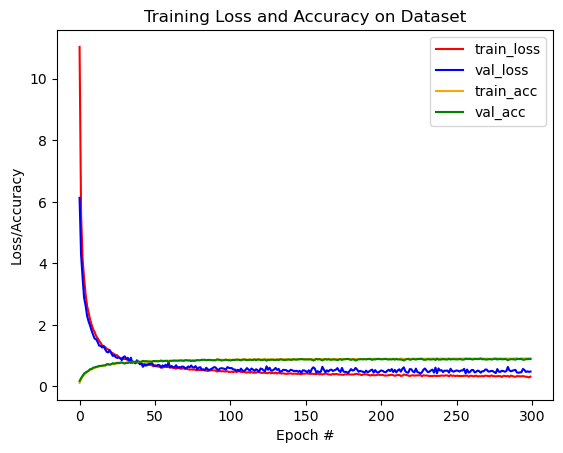

In [30]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Save Model History to csv

In [31]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save and Test The Model to Predict Video

In [32]:
current_datetime = datetime.now()

# Save Model
workout_model.save(f'workout_model2')

# Save .h5 model
workout_model.save(f'workout_model2.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./workout_model')
tflite_model = converter.convert()

# Save the tflite model
with open(f'workout_model2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: workout_model2\assets


INFO:tensorflow:Assets written to: workout_model2\assets
